In [5]:
#!/usr/bin/env /share/share1/share_dff/anaconda3/bin/python

"""
Author: Lira Mota, lmota20@gsb.columbia.edu
Course: Big Data in Finance (Spring 2019)
Date: 2019-02
Code:
    Creates stock_monthly pandas data frame.
    Import CRSP MSE and MSF.

Dependence:
-----------
fire_pytools

Notes:
------
Calculates:
    Book-equity (BE),
    Operating profits (OP) and Operating profitability (OP/BE),
    Investment (INV),
    Earnings,
    Dividends,
    Cash flow and  free cash flow,
    Gross profits
    Leverage

"""

"""
Compustat XpressFeed Variables:
* AT      = Total Assets
* CAPX    = Capital Expenditures
* CEQ     = Common/Ordinary Equity - Total
* COGS    = Cost of Goods Sold
* CSHO    = Common Shares Outstanding
* DLC     = Debt in Current Liabilities
* DLTIS   = Long-Term Debt - Issuance
* DLCCH   = Current Debt - Changes
* DLTT    = Long-Term Debt - Total
* DLTR    = Long-Term Debt - Reduction
* DP      = Depreciation and Amortization
* DV      = Cash Dividends
* DVC     = Divdends common/ordinary
* DVP     = Dividends - Preferred/Preference
* EMP     = Number of Employees
* GP      = Gross Profits
* IB      = Income Before Extraordinary Items
* ICAPT   = Invested Capital - Total
* ITCB    = Investment Tax Credit (Balance Sheet)
* LT      = Total Liabilities
* MIB     = Minority Interest (Balance Sheet)
* NAICS   = North American Industrial Classification System Variable Name
* NAICSH  = North American Industry Classification Codes - Historical Company Variable Name
* NI      = Net Income
* OIADP   = Operating Income After Depreciation
* OIBDP   = Operating Income Before Depreciation
* PPEGT   = "Property, Plant and Equipment - Total (Gross)"
* PRBA    = Postretirement Benefit Assets (from separate pension annual file)
* PRSTKC  = Purchase of Common Stock
* PRSTKCC = Purchase of Common Stock (Cash Flow)
* PSTKRV  = Preferred Stock Redemption Value
* PSTK    = Preferred/Preference Stock (Capital) - Total (kd: = par?)
* PSTKL   = Preferred Stock Liquidating Value
* PSTKRV  = Preferred Stock Liquidating Value
* RE      = Retained Earnings
* REVT    = Revenue - Total
* SALE    = Sales/Turnover Net
* SEQ     = Shareholders Equity
* SIC     = Standard Industrial Classification Code
* SSTK    = Sale of Common and Preferred Stock
* TXDB    = Deferred Taxes Balance Sheet
* TXDI    = Income Taxes - Deferred
* TXDITC  = Deferred Taxes and Investment Tax Credit
* WCAPCH  = Working Capital Change - Total
* XINT    = Interest and Related Expense - Total
* XLR     = Staff Expense - Total
* XRD     = Research and Development Expense
* XSGAQ   = Selling, General and Administrative Expenses (millions)

"""

# %% Packages
import wrds
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.offsets import MonthEnd

from fire_pytools.utils.pk_integrity import *
from fire_pytools.utils.post_event_nan import *

from fire_pytools.import_wrds.compd_fund import *
from fire_pytools.import_wrds.compd_aco_pnfnd import *
from fire_pytools.import_wrds.crsp_sf import *
from fire_pytools.import_wrds.merge_comp_crsp import *
from fire_pytools.import_kf.dff_be import *

# %% Functions


def calculate_be(df):
    """
    BE = Share Equity(se) - Prefered Stocks(ps) + Deferred Taxes(dt) - Post retirement Benefit Assets(prba)

    Parameters
    ----------
    df: data frame
        Compustat table with columns ['seq', 'ceq', 'at', 'lt', 'mib', 'pstkrv', 'pstkl', 'pstk', 'txditc', 'txdb', 'itcb', 'prba']

    Definition:
    -----------
    BE is the stockholders book equity, plus balance sheet deferred taxes and investment tax credit (if available),  minus the book value
    of preferred stock. Depending on availability, we use redemption, liquidation, or par value (in that order) for the book value of preferred stock.
    Stockholders equity is the value reported by Moody or COMPUSTAT, if it is available.
    If not, we measure stockholders equity as the book value of common equity plus the par value of preferred stock,
    or the book value of assets minus total liabilities (in that order)".* DFF, JF, 2000, pg 393.
    This is the definition posted on Ken French website:

    """

    required_cols = ['fyear', 'seq', 'ceq', 'at', 'lt', 'mib', 'pstkrv', 'pstkl', 'pstk', 'txditc', 'txdb', 'itcb', 'prba']

    assert set(required_cols).issubset(df.columns), 'Following funda dataitems needed: {}'.format(required_cols)

    df = df[required_cols].copy()

    # Shareholder Equity
    df['se'] = df['seq']

    # Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
    df['se'].fillna((df['ceq'] + df['pstk']), inplace=True)

    # Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
    df['se'].fillna((df['at'] - df['lt'] + df['mib'].fillna(0)), inplace=True)

    # Preferred Stock
    # Preferred Stock (Redemption Value)
    df['ps'] = df['pstkrv']
    # Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing
    df['ps'].fillna(df['pstkl'], inplace=True)
    # Uses Preferred Stock (Carrying Value (pstk)) if others are missing
    df['ps'].fillna(df['pstk'], inplace=True)

    # Deferred Taxes
    # Uses Deferred Taxes and Investment Tax Credit (txditc)
    df['dt'] = df['txditc']

    # This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
    # Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing

    df['dt'].fillna((df['txdb'].fillna(0) + df['itcb'].fillna(0)), inplace=True)
    # If all measures are missing, set dt to missing
    df.loc[pd.isnull(df['txditc']) & pd.isnull(df['txdb']) & pd.isnull(df['itcb']), 'dt'] = np.nan

    df.loc[df['fyear'] >= 1993, 'dt'] = 0

    # Book Equity
    # Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
    BE = (df['se']  # shareholder equity must be available, otherwise BE is missing
          - df['ps']  # preferred stock must be available, otherwise BE is missing
          + df['dt'].fillna(0)  # add deferred taxes if available
          - df['prba'].fillna(0))  # subtract postretirement benefit assets if available

    return BE


def calculate_op(df):
    """
    Operating Profitability (OP)
    Revenues (SALE (? not sure)) minus cost of goods sold (ITEM 41/COGS), minus selling, general, and administrative expenses (ITEM 189/XSGA),
    minus interest expense (ITEM 15/XINT (? Not Sure)) all divided by book equity.

    Fama, French (2015, JFE, pg.3)
    Ken Frech's website:
    The portfolios for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have ME for December of t-1 and June of t,
    (positive) BE for t-1, non-missing revenues data for t-1, and non-missing data for at least one of the following: cost of goods sold, selling,
    general and administrative expenses, or interest expense for t-1.
    """
    required_cols = ['sale', 'cogs', 'xsga', 'xint', 'be']

    assert set(required_cols).issubset(df.columns), 'Following funda dataitems needed: {}'.format(required_cols)

    df = df[required_cols].copy()

    df['cost'] = df[['cogs', 'xsga', 'xint']].sum(axis=1, skipna=True)
    df.loc[df[['cogs', 'xsga', 'xint']].isnull().all(axis=1), 'cost'] = np.nan

    df['op'] = df['sale'] - df['cost']
    df.loc[(df.be > 0), 'opbe'] = df['op'] / df['be']

    return df['op'], df['opbe']


def calculate_inv(df):
    """
    Investment (INV)
    The change in total assets from the fiscal year ending in year t-2 to the fiscal year ending in t-1, divided by t-2 total assets.
    Fama, French (2015, JFE, pg.3)

    Notes:
    ------
    Ken Frech's website:
    The portfolios for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have market equity data for June of t and total assets
    data for t-2 and t-1.
    """

    required_cols = ['datadate', 'gvkey', 'fyear', 'at']

    assert set(required_cols).issubset(df.columns), 'Following funda dataitems needed: {}'.format(required_cols)

    df = df[required_cols].copy()

    if any(df.fyear.isnull() & df['at'].notnull()):
        warnings.warn('''Missing fyear with valid at value. Row was arbitrarily deleted. ''')

    # Notice that [gvkey, fyear] is not a primary key for compustat.
    # There are some cases in which there are 2 datadate for the same fyear.
    # In many cases there is one of them have missing.  In this case we keep the entry that is not missing.
    df = df[df.fyear.notnull()]
    df = df[df['at'] > 0]

    pk_integrity(df, ['gvkey', 'fyear'])

    df.sort_values(['gvkey', 'fyear'], inplace=True)
    df['lag_at'] = df.groupby('gvkey').at.shift(1)
    df['inv'] = (df['at'] - df['lag_at']) / df['lag_at']

    # Take care if there are years missing
    df['fdiff'] = df.groupby('gvkey').fyear.diff()
    df.loc[df.fdiff > 1, 'inv'] = np.nan

    # df[df['gvkey'] == '018073']

    return df['inv']

# %% Main Function


def main(save_out=True):

    print("Stock annual calculation.")
    # %% Set Up
    db = wrds.Connection(wrds_username='nkoont')  # make sure to configure wrds connector before hand.
    DATAPATH = "/Users/nkk2115/Factors_Project_Final/" # where to save output?

    start_time = time.time()

    # %% Import Data

    varlist = ['conm', 'fyear', 'fyr', 'at', 'capx', 'ceq', 'cogs', 'dlc', 'ib', 'icapt', 'itcb', 'lt', 'mib',
               'naicsh', 'pstk', 'pstkl', 'pstkrv',  'sale', 'seq', 'sich', 'sstk', 'txdb', 'txdi', 'txditc',
               'xint', 'xsga']
    start_date = '1950-01-01'  # '2017-01-01'#
    end_date = datetime.date.today().strftime("%Y-%m-%d")
    freq = 'annual'

    # Download firms fundamentals from Compustat.
    comp_data = compd_fund(varlist=varlist, start_date=start_date, end_date=end_date, freq='annual', db=db)

    del varlist

    # Download pension data
    varlist_aco = ['prba']
    pension_data = compd_aco_pnfnd(varlist=varlist_aco, start_date=start_date, end_date=end_date, freq=freq, db=db)

    del varlist_aco

    # Download Davis, Fama, French BE Data
    dff = dff_be()

    # CRSP ME Data
    varlist_crsp = varlist = ['exchcd', 'naics', 'permco', 'prc', 'shrcd', 'shrout', 'siccd', 'ticker']
    start_date = '1925-01-01'  # '2017-01-01' #
    end_date = datetime.date.today().strftime("%Y-%m-%d")
    freq = 'monthly'  # 'daily'
    crspm = crsp_sf(varlist_crsp,
                    start_date,
                    end_date,
                    freq=freq,
                    db=db)

    del varlist_crsp

    # Merge
    comp = pd.merge(comp_data, pension_data, on=['gvkey', 'datadate'], how='left')

    del (comp_data, pension_data)

    # %% Add variables

    # Add BE
    comp['be'] = calculate_be(comp)

    # Add OP: naming here is to be consistent with risk and returns projects.
    comp['op'], comp['opbe'] = calculate_op(comp)

    # Add INV
    comp['inv_gvkey'] = calculate_inv(comp)
    # comp.loc[comp.gvkey == '006557', ['gvkey', 'datadate', 'fyear', 'inv']]
    # comp.loc[comp.gvkey == '001414', ['gvkey','datadate','fyear','inv','at']]

    # There are 2 entries in which fyear is missing. All variables are null in these cases.
    # comp.loc[comp['fyear'].isnull(), ['gvkey', 'cusip', 'permno', 'fyear', 'at', 'be']]
    comp.dropna(subset=['fyear'], inplace=True)

    # Merged data set has [permno, datadate] as primary key. We need ['permno', 'fyear'] as primary key.
    # Six duplicated cases in which we choose the latest observation.
    # comp[comp[['permno', 'fyear']].duplicated(keep=False)][['permno', 'gvkey', 'datadate', 'fyear', 'at']]
    # comp[comp['permno']==22074][['permno', 'gvkey', 'datadate', 'fyear', 'at']]

    # These are cases where the gvkey changes (probably merger) and the fiscal-year-end (fyr) also changes
    # by keeping last, we put the merger investment into the year it happens
    # That seems reasonable
    comp = comp[~comp.duplicated(subset=['gvkey', 'fyear'], keep='last')]

    # Add rankyear
    comp['rankyear'] = comp['fyear'] + 1

    # %% Add CRSP Variables

    # Link CRSP/Compustat table
    lcomp = merge_compustat_crsp(comp, db=db)
    # Link CRSP/Compustat table
    lcomp = merge_compustat_crsp(comp, db=db)
    print("CRSP and Compsuat merge created %d (fyear, permno) duplicates." %lcomp[lcomp.duplicated(subset=['permno', 'fyear'])].shape[0])
    print("Keeping only the last available datadate per PERMNO.")

    lcomp.sort_values(by=['permno', 'fyear', 'datadate'])
    lcomp = lcomp[~lcomp.duplicated(subset=['permno', 'fyear'], keep='last')]

    #  Calculate INV by PERMCO
    lcomp.sort_values(['permno', 'fyear'], inplace=True)
    lcomp['lag_at'] = lcomp.groupby('permno').at.shift(1)
    lcomp['inv'] = (lcomp['at'] - lcomp['lag_at']) / lcomp['lag_at']
    # Take care if there are years missing
    lcomp['fdiff'] = lcomp.groupby('permno').fyear.diff()
    lcomp.loc[lcomp.fdiff > 1, 'inv'] = np.nan
    lcomp.loc[(lcomp['at'] <= 0), 'inv'] = np.nan
    lcomp.loc[(lcomp['lag_at'] <= 0), 'inv'] = np.nan
    lcomp.drop(columns=['lag_at', 'fdiff'], inplace=True)

    # Add Davis data
    dff.rename(columns={'be': 'be_dff'}, inplace=True)
    # Add PERMCO to DFF data: Important for ME sum later
    pp_key = crspm[['permno', 'permco']].drop_duplicates()
    # max(pp_key.groupby(['permno']).permco.count())
    dff = pd.merge(dff, pp_key, on=['permno'], how='left')

    print('There are %d PERMNOs without a valid PERMCO: not present in the crspm table.' % dff[dff.permco.isnull()].permno.unique())

    lcomp = pd.merge(lcomp, dff, on=['permno', 'permco', 'rankyear'], how='outer')
    lcomp.be.fillna(lcomp['be_dff'], inplace=True)
    lcomp.drop(columns=['be_dff'], inplace=True)
    lcomp.fyear.fillna(lcomp['rankyear'] - 1, inplace=True)

    print('Number of not valid PERMCOs lcomp: %d' % round(lcomp.permco.isnull().sum() / lcomp.shape[0], 4))

    del dff, pp_key
    ## Notice that, since int does not support null, outer merge changes dtype of permco

    lcomp.sort_values(['permno', 'rankyear'], inplace=True)

    # ME, SICCD, TICKER, exchcd and shrcrd from June
    crspm['me'] = crspm.prc.abs()*crspm.shrout

    crspjune = crspm.loc[crspm.date.dt.month == 6, ['permno', 'permco', 'date', 'me', 'exchcd', 'shrcd', 'ticker', 'siccd']]
    crspjune['rankyear'] = crspjune.date.dt.year
    crspjune.drop('date', axis=1, inplace=True)
    stock_annual = lcomp.merge(crspjune, how='outer', on=['permno', 'permco', 'rankyear'])
    stock_annual.sort_values(['permno', 'rankyear'], inplace=True)

    # For summing size over issues of the same firm:
    # we rely on gvkey first
    # and if there is no gvkey (e.g. before lcompustat sample period) we use PERMCO
    stock_annual['gvkey_permco'] = stock_annual.gvkey.fillna(stock_annual['permco'])
    stock_annual['mesum_june'] = stock_annual.groupby(['fyear', 'gvkey_permco'])['me'].transform(np.sum, min_count=1)
    stock_annual.rename(columns={'me': 'mejune'}, inplace=True)
    del crspjune

    # Calculate ME december
    crspdec = crspm.loc[crspm.date.dt.month == 12, ['permno', 'date', 'me']]
    crspdec['fyear'] = crspdec.date.dt.year
    crspdec.drop('date', axis=1, inplace=True)
    crspdec.rename(columns={'me': 'medec'}, inplace=True)
    stock_annual = pd.merge(stock_annual, crspdec, how='left', on=['permno', 'fyear'])
    stock_annual['mesum_dec'] = stock_annual.groupby(['fyear', 'gvkey_permco'])['medec'].transform(np.sum, min_count=1)
    del crspdec, lcomp

    # Calculate book-to-market
    # In accordance with FF1993 and DFF2000 the BEME used to form portfolios in June of year t,
    # is BE for the fiscal year ending in t-1, divided by ME at December of t-1. ME for December
    stock_annual.loc[(stock_annual.be > 0), 'beme'] = stock_annual['be'] / stock_annual['mesum_dec']
    stock_annual.loc[(stock_annual.mesum_dec == 0) | (stock_annual.mesum_dec.isnull()), 'beme'] = np.nan

    # Calculate again variables that depend on be values. Need to consider the DFF data OP
    stock_annual.loc[(stock_annual.be > 0), 'opbe'] = stock_annual['op'] / stock_annual['be']

    # Add CRSP SIC when missing
    stock_annual.sich.fillna(stock_annual['siccd'], inplace=True)

    # Back fill SIC code
    stock_annual['sich_filled'] = stock_annual.sich.copy()
    stock_annual['sich_filled'] = stock_annual.groupby('permno').sich_filled.fillna(method='bfill')
    stock_annual['sich_filled'] = stock_annual.groupby('permno').sich_filled.fillna(method='ffill')

    print('Number of entries with valis sich:')
    print(round(pd.isnull(stock_annual.sich).sum() / stock_annual.shape[0], 4))
    print('Number of entries with valis sich_filled:')
    print(round(pd.isnull(stock_annual.sich_filled).sum() / stock_annual.shape[0], 4))

    pk_integrity(stock_annual, ['permno', 'rankyear'])
    stock_annual.sort_values(['permno', 'rankyear'], inplace=True)

    stock_annual.drop(columns=['gvkey_permco'], inplace=True)

    print("Time to create stock_annual: %s seconds" % str(time.time() - start_time))

    if save_out:
        stock_annual.to_pickle(DATAPATH + 'stock_annual.pkl')
        print("Successfully saved stock_annual.")

    return stock_annual

# %% Main


if __name__ == '__main__':
    main()
    

Stock annual calculation.


/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Loading library list...
Done
Compustat data was successfully downloaded in 13.975378036499023 seconds.
Pension data was successfully downloaded in 0.907965898513794 seconds.
CRSP data was successfully downloaded in 84.83428287506104 seconds.
CRSP and Compsuat merge created 6 (fyear, permno) duplicates.
Keeping only the last available datadate per PERMNO.
There are 81664 PERMNOs without a valid PERMCO: not present in the crspm table.
Number of not valid PERMCOs lcomp: 0
Number of entries with valis sich:
0.0457
Number of entries with valis sich_filled:
0.0031
Time to create stock_annual: 125.12136316299438 seconds
Successfully saved stock_annual.


In [6]:
#!/usr/bin/env /share/share1/share_dff/anaconda3/bin/python

"""
Author: Lira Mota, lmota20@gsb.columbia.edu
Course: Big Data in Finance (Spring 2019)
Date: 2019-02
Code:
    Creates stock_monthly pandas data frame.
    Import CRSP MSE and MSF.

------

Dependence:
fire_pytools

"""

# %% Packages
import wrds
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.offsets import MonthEnd

from fire_pytools.import_wrds.crsp_sf import *
from fire_pytools.utils.post_event_nan import *

def calculate_melag(mdata):
    """
     Parameters:
    ------------
    mdata: data frame
        crsp monthly data with cols permno, date as index and lag_me column

    Notes:
    ------
    If ME is missing, we do not exclude stock, but rather keep it in with last non-missing MElag.
    The stock will be excluded if:
    (i) Delisted;
    (ii) Have a missing ME in the moment of portfolio construction.

    This is different than Ken's method

    EXAMPLE:
    --------
    there seem to be 12 stocks with missing PRC and thus missing ME in July 1926.
    Thus, our number of firms drops from 428 to 416.
    Fama and French report 427 in both July and August, so they also do not seem to exclude these
    rather they probably use the previous MElag for weight and must assume some return in the following month.

    The whole paragraph from the note on Ken French's website:
    ----------------------------------------------------------
    "In May 2015, we revised the method for computing daily portfolio returns
    to match more closely the method for computing monthly portfolio returns.
    Daily files produced before May 2015 drop stocks from a portfolio
    (i) the next time the portfolio is reconstituted, at the end of June, regardless of the CRSP delist date or
    (ii) during any period in which they are missing prices for more than 10 consecutive trading days.
    Daily files produced after May 2015 drop stocks from a portfolio
    (i) immediately after their CRSP delist date or
    (ii) during any period in which they are missing prices for more than 200 consecutive trading days. "
    """

    required_cols = ['lag_me', 'lag_dlret']

    set(required_cols).issubset(mdata.columns), "Required columns: {}.".format(', '.join(required_cols))

    df = mdata[required_cols].copy()
    df['melag'] = df.groupby('permno').lag_me.fillna(method='pad')
    df.reset_index(inplace=True)

    # Fill na after delisting
    df = post_event_nan(df=df, event=df.lag_dlret.notnull(), vars=['melag'], id_vars=['permno', 'edate'])

    df.set_index(['permno', 'edate'], inplace=True)

    return df[['melag']]

def calculate_cumulative_returns(mdata, tt, min_periods): #TODO: to be completed
    """
    Calculate past returns for momentum stratagy

    Parameters:
    ------------
    mdata: data frame
        crsp monthly data with cols permno, date as index.
    tt: int
        number of periods to cumulate retuns
    min_periods: int
        minimum number of periods. Default tt/2
    """
    start_time = time.time()

    required_cols = ['retadj']

    assert set(required_cols).issubset(mdata.columns), "Required columns: {}.".format(', '.join(required_cols))

    df = mdata[required_cols].copy()
    df['retadj'] = df['retadj']+1
    df['ret'] = df['ret'].notnull()

    df.reset_index(level=0, inplace=True)

    # Cumulative Return (adjusted) in 11 months
    # cret = df.groupby([...]).[].rolling(window=tt, min_periods=1).apply(np.prod, raw=True)
    # nona_count = df.groupby([...]).[].ret.rolling(window=tt, min_periods=1).apply(np.sum, raw=True)

    # cret = cret-1
    # cret = cret.to_frame('ret' + str(tt))
    # cret[nona_count <= min_periods] = np.nan

    print("Time to calculate %d months past returns: %s seconds" % (tt, str(round(time.time() - start_time, 2))))

    return cret

# %% Main Function


def main(save_out=True):

    # %% Set Up
    db = wrds.Connection(wrds_username='nkoont')  # make sure to configure wrds connector before hand.
    DATAPATH = "/Users/nkk2115/Factors_Project_Final/" # where to save output?


    start_time = time.time()

    # %% Download CRSP data
    varlist = ['dlret', 'dlretx', 'exchcd', 'naics', 'permco', 'prc', 'ret', 'shrcd', 'shrout', 'siccd', 'ticker']

    start_date = '1925-01-01'  # '2017-01-01' #
    end_date = datetime.date.today().strftime("%Y-%m-%d")
    freq = 'monthly'  # 'daily'
    permno_list = None  # [10001, 14593, 10107] #
    shrcd_list = None  # [10, 11] #
    exchcd_list = None  # [1, 2, 3] #
    crspm = crsp_sf(varlist,
                    start_date,
                    end_date,
                    freq=freq,
                    permno_list=permno_list,
                    shrcd_list=shrcd_list,
                    exchcd_list=exchcd_list,
                    db=db)


    # %% Create variables

    # Rankyear
    # Rankyear is the year where we ranked the stock, e.g., for the return of a stock in January 2001,
    # rankyear is 2000, because we ranked it in June 2000
    crspm['rankyear'] = crspm.date.dt.year
    crspm.loc[crspm.date.dt.month <= 6, 'rankyear'] = crspm.loc[crspm.date.dt.month <= 6, 'rankyear'] - 1

    # Returns adjusted for delisting
    crspm['retadj'] = ((1 + crspm['ret'].fillna(0)) * (1 + crspm['dlret'].fillna(0)) - 1)
    crspm.loc[crspm[['ret', 'dlret']].isnull().all(axis=1), 'retadj'] = np.nan

    # Create Market Equity (ME)
    # SHROUT is the number of publicly held shares, recorded in thousands. ME will be reported in 1,000,000 ($10^6$).
    # If the stock is delisted, we set ME to NaN.
    # Also, some companies have multiple shareclasses (=PERMNOs).
    # To get the company ME, we need to calculate the sum of ME over all shareclasses for one company (=PERMCO).
    # This is used for sorting, but not for weights.
    crspm['me'] = abs(crspm['prc']) * (crspm['shrout'] / 1000)

    # Create MEsum
    crspm['mesum_permco'] = crspm.groupby(['date', 'permco']).me.transform(np.sum, min_count=1)

    # Adjust for delisting
    crspm.loc[crspm.dlret.notnull(), 'me'] = np.nan
    crspm.loc[crspm.dlret.notnull(), 'mesum'] = np.nan

    # Resample data (This takes about 9 min)
    # CRSP data has skipping months.
    # Create line to missing  months to facilitate the calculation of lag/past returns
    start_time1 = time.time()
    crspm['edate'] = crspm['date'] + MonthEnd(0)
    crspm.sort_values(['permno', 'edate'], inplace=True)
    pk_integrity(crspm, ['permno', 'edate'])
    crspm.set_index('edate', inplace=True)

    # Resample to take care of missing months
    scrspm = crspm[['permno', 'me', 'dlret']].groupby('permno').resample('M').mean().drop(columns='permno')  # mean maintains nan
    scrspm = scrspm.groupby('permno').shift(1)
    scrspm.columns = ['lag_' + i for i in scrspm.columns]

    crspm.reset_index(inplace=True)
    crspm.set_index(['permno', 'edate'], inplace=True)

    crspm = crspm.join(scrspm, how='outer')

    print("Time to resample data: %s seconds" % str(time.time() - start_time1))

    # Create MElag
    crspm['melag'] = calculate_melag(crspm)

    # TODO: Calculate past 11, 1 returns

    # Delete rows that were not in the original data set
    crspm.dropna(subset=['date'], inplace=True)
    crspm.drop(columns=[x for x in crspm.columns if 'lag_' in x], inplace=True)

    crspm.sort_values(['permno', 'date'], inplace=True)

    print("Time to create CRSP monthly: %s seconds" % str(time.time() - start_time))

    if save_out:
        crspm.to_pickle(DATAPATH+'stock_monthly.pkl')
        print("Successfully saved stock_monthly.")
    return crspm


# %% Main
if __name__ == '__main__':
    main()


Loading library list...
Done
CRSP data was successfully downloaded in 103.80368113517761 seconds.
Time to resample data: 131.7138171195984 seconds
Time to create CRSP monthly: 255.15274286270142 seconds
Successfully saved stock_monthly.


In [7]:
import pandas as pd
import wrds
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

In [8]:
# First, I downloaded the files to compile stock_monthly.pkl and stock_annual.pkl

monthly = pd.read_pickle('/Users/nkk2115/Factors_Project_Final/stock_monthly.pkl')
annual = pd.read_pickle('/Users/nkk2115/Factors_Project_Final/stock_annual.pkl')
monthly['index'] = range(1, len(monthly.index)+1)

In [80]:
ff = pd.read_csv('/Users/nkk2115/Desktop/hm_ii/ffmonthly.CSV')
ffmom = pd.read_csv('/Users/nkk2115/Factors_Project_Final/ffmomentum.CSV')

In [9]:
#sort data
sort_data = monthly[monthly.shrcd.isin([10,11])].copy()
sort_data = sort_data[sort_data.exchcd.isin([2,3,4])]

#need BEME and OPBE > 0, for INV need AT and ATlag to be positive, and for SMB need all of the above.
#select stocks for which have market equity data for december of t-1 and june of t
#a company can have a valid BEME and not a valid investment, the universes are different, thus the number of stock across sorts can be different
# sample_filters[sortvar] = ... this remains to do for next week


In [10]:
#now, calculate rolling cumulative returns for momentum factor:

def calculate_cumulative_returns(mdata, tt, min_periods):
    required_cols = ['retadj', 'ret']

    assert set(required_cols).issubset(mdata.columns), "Required columns: {}.".format(', '.join(required_cols))

    df = mdata[required_cols].copy()
    df['retadj'] = df['retadj']+1

    df.reset_index(level=0, inplace=True)

    # Cumulative Return (adjusted) in 11 months
    cret = df.groupby('permno')['retadj'].rolling(window=tt, min_periods=6).apply(np.prod, raw=True)
    nona_count = df.groupby('permno')['retadj'].rolling(window=tt, min_periods=6).apply(np.sum, raw=True)

    cret = cret-1
    cret = cret.to_frame('retadj' + str(tt))
    cret[nona_count <= min_periods] = np.nan
    return cret

returnsdf = calculate_cumulative_returns(monthly, 11, 6)

monthly['ret_11_1'] = returnsdf

In [12]:
from fire_pytools.portools.sort_portfolios import *
#first calculate breakpoints, because each has different universe
#make sure to include: exch_cd=[1]
# br_me=find_breakpoints(data=crspa, quantiles={'mesum_dec':[0.5]}, id_variables=['rankyear','permno','exch_cd'], exch_cd=[1])
# br_in=find_breakpoints(data=crspa, quantiles={'inv':[0.3,0.7]}, id_variables=['rankyear','permno','exch_cd'], exch_cd=[1])
# br_be=find_breakpoints(data=crspa, quantiles={'beme':[0.3,0.7]}, id_variables=['rankyear','permno','exch_cd'], exch_cd=[1])
# br_op=find_breakpoints(data=crspa, quantiles={'op':[0.3,0.7]}, id_variables=['rankyear','permno','exch_cd'], exch_cd=[1])

# Sort Portfolios
sorts = sort_portfolios(data=annual,
                       quantiles={'mesum_dec': [0.5], 'beme': [0.3,0.7], 'op': [0.3,0.7],'inv':[0.3,0.7]},
                       id_variables=['rankyear', 'permno', 'exch_cd'])

Breakpoints were calculated for mesum_dec.
Stocks were sorted according to breakpoints, starting in 1926.0
Breakpoints were calculated for beme.
Stocks were sorted according to breakpoints, starting in 1926.0
Breakpoints were calculated for op.
Stocks were sorted according to breakpoints, starting in 1951.0
Breakpoints were calculated for inv.
Stocks were sorted according to breakpoints, starting in 1952.0


In [33]:
#do the same for momentum input cumulative 11-1 return:
sortsm = sort_portfolios(data=monthly,
                       quantiles={'ret_11_1':[0.3,0.7]},
                       id_variables=['rankyear', 'permno', 'exchcd'])

Breakpoints were calculated for ret_11_1.
Stocks were sorted according to breakpoints, starting in 1926.0


In [34]:
monthly1 = monthly.merge(sortsm,how='right',on=['rankyear','permno'], right_index=False)

In [13]:
#now we are going to merge

annual1 = annual.merge(sorts,how='right',on=['rankyear','permno'], right_index=False)
annual1['rankyear']=annual1['fyear']

In [35]:
combined = annual1.merge(monthly1, on=['permno', 'rankyear'])

In [36]:
#calculate factor returns
def weightedavg(group, avg, weight):
    d = group[avg]
    w = group[weight]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()


combined = combined[(combined.fyear >= 1964)]


#HML
chars = ['mesum_dec', 'beme']
beme_returns = combined.groupby(['date']+[char+"portfolio" for char in chars]).apply(weightedavg, 'retadj', 'melag')
beme_returns = beme_returns.unstack(level=[1,2])
hml = (beme_returns['mesum_dec1','beme3']+beme_returns['mesum_dec2','beme3'])/2-(beme_returns['mesum_dec1','beme1']
                                                                                 +beme_returns['mesum_dec2','beme1'])/2
hml = hml.to_frame()
hml.reset_index(level = 0, inplace = True)

#RMW
chars = ['mesum_dec', 'op']
op_returns = combined.groupby(['date']+[char +"portfolio" for char in chars]).apply(weightedavg, 'retadj', 'melag')
op_returns = op_returns.unstack(level=[1,2])
rmw = (op_returns['mesum_dec1','op3']+op_returns['mesum_dec2','op3'])/2-(op_returns['mesum_dec1','op1']
                                                                         +op_returns['mesum_dec2','op1'])/2
rmw = rmw.to_frame()
rmw.reset_index(level = 0, inplace = True)

#CMA
chars = ['mesum_dec', 'inv']
inv_returns = combined.groupby(['date']+[char +"portfolio" for char in chars]).apply(weightedavg, 'retadj', 'melag')
inv_returns = inv_returns.unstack(level=[1,2])
cma = (inv_returns['mesum_dec1','inv3']+inv_returns['mesum_dec2','inv3'])/2-(inv_returns['mesum_dec1','inv1']
                                                                             +inv_returns['mesum_dec2','inv1'])/2
cma = cma.to_frame()
cma.reset_index(level = 0, inplace = True)

#SMB
smb=( (beme_returns['mesum_dec1','beme1']+beme_returns['mesum_dec1','beme2']+beme_returns['mesum_dec1','beme3'])/3
-(beme_returns['mesum_dec2','beme1']+beme_returns['mesum_dec2','beme2']+beme_returns['mesum_dec2','beme3'])/3 +
(inv_returns['mesum_dec1','inv1']+inv_returns['mesum_dec1','inv2']+inv_returns['mesum_dec1','inv3'])/3
      -(inv_returns['mesum_dec2','inv1']+inv_returns['mesum_dec2','inv2']+inv_returns['mesum_dec2','inv3'])/3+
(op_returns['mesum_dec1','op1']+op_returns['mesum_dec1','op2']+op_returns['mesum_dec1','op3'])/3
      -(op_returns['mesum_dec2','op1']+op_returns['mesum_dec2','op2']+op_returns['mesum_dec2','op3'])/3)/3

smb = smb.to_frame()
smb.reset_index(level = 0, inplace = True)

In [58]:
#HML
hml = (beme_returns['mesum_dec1','beme1']+beme_returns['mesum_dec2','beme1'])/2-(beme_returns['mesum_dec1','beme3']
                                                                                 +beme_returns['mesum_dec2','beme3'])/2
hml = hml.to_frame()
hml.reset_index(level = 0, inplace = True)

In [62]:
#HML
hml = (beme_returns['mesum_dec1','beme3']+beme_returns['mesum_dec2','beme3'])/2-(beme_returns['mesum_dec1','beme1']
                                                                                 +beme_returns['mesum_dec2','beme1'])/2
hml = hml.to_frame()
hml.reset_index(level = 0, inplace = True)

In [39]:
chars = ['mesum_dec', 'ret_11_1']

mom_ret = combined.groupby(['date']+[char+"portfolio" for char in chars]).apply(weightedavg, 'retadj', 'melag')
mom_ret = mom_ret.unstack(level=[1,2])

In [42]:
mom = (mom_ret['mesum_dec1','ret_11_13']+mom_ret['mesum_dec1','ret_11_13'])/2-(mom_ret['mesum_dec2','ret_11_11']+mom_ret['mesum_dec2','ret_11_11'])/2
mom = mom.to_frame()
mom.reset_index(level = 0, inplace = True)

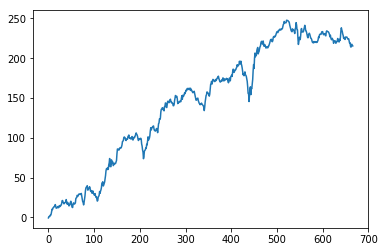

In [113]:
hml_sum = hml[0].cumsum()
HML_sum = ff['HML'].cumsum()
plt.plot(HML_sum)

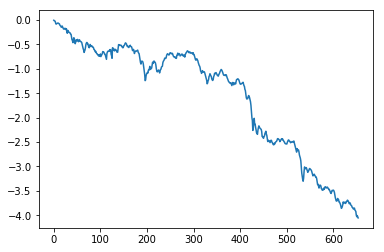

In [105]:
plt.plot(hml_sum)

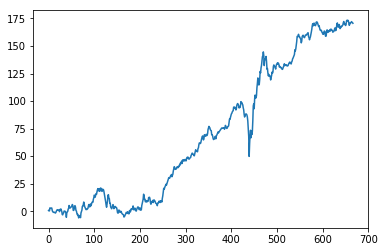

In [114]:
rmw_sum = rmw[0].cumsum()
RMW_sum = ff['RMW'].cumsum()
plt.plot(RMW_sum)

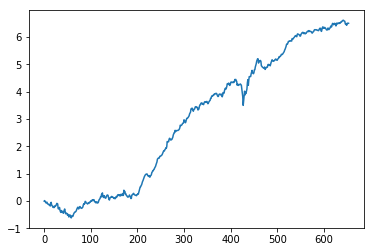

In [101]:
plt.plot(rmw_sum)

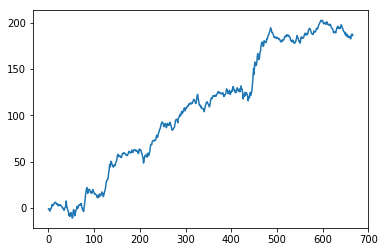

In [115]:
cma_sum = cma[0].cumsum()
CMA_sum = ff['CMA'].cumsum()
plt.plot(CMA_sum)

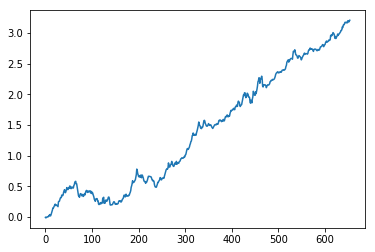

In [99]:
plt.plot(cma_sum)

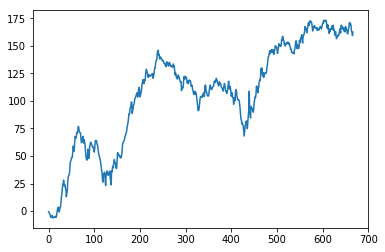

In [116]:
smb_sum = smb[0].cumsum()
SMB_sum = ff['SMB'].cumsum()
plt.plot(SMB_sum)

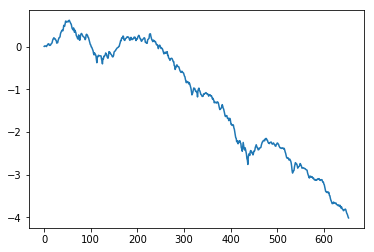

In [97]:
plt.plot(smb_sum)

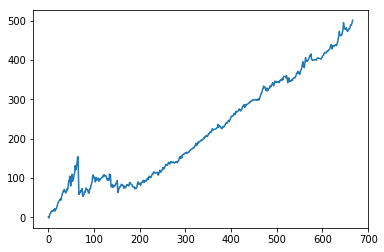

In [117]:
mom_sum = mom[0].cumsum()
MOM_sum = ff['mom'].cumsum()
plt.plot(MOM_sum)

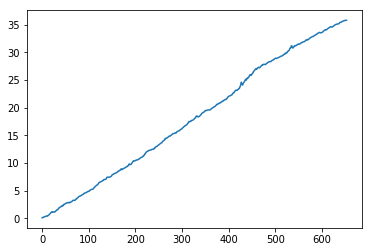

In [94]:
plt.plot(mom_sum)

In [88]:
ff['mom']= ffmom['Mom   ']

In [91]:
ff['mySMB'] = smb[0]
ff['myHML'] = hml[0]
ff['myRMW'] = rmw[0]
ff['mymom'] = mom[0]
ff['myCMA'] = cma[0]

In [92]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = ff.corr()
corr.style.background_gradient()

**Clearly my fama french factors leave something to be desired. I will try to improve them for next week**

Above, I see that the often the general shape of the my constructed factors follows that of FF factors, however the scale is completely wrong (and sometimes the direction). I need to go back through the methodology of constructing the factors to see why this is happening.